In [1]:
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [5]:
import pandas as pd
dataset_ex_df = pd.read_csv("C:/Users/janiv/Downloads/AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [6]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2010-01-04,133.899994
1,2010-01-05,134.690002
2,2010-01-06,132.250000


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2265 number of days in the dataset.


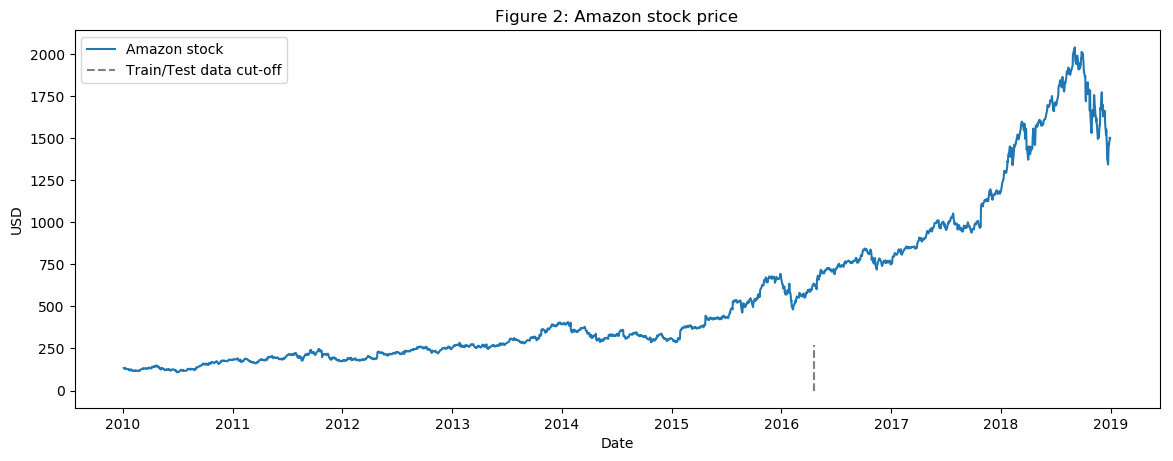

In [9]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Amazon stock')
plt.vlines(datetime.date(2016,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Amazon stock price')
plt.legend()
plt.show()

In [8]:

def get_technical_indicators(dataset):
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    
    
    return dataset

In [9]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [10]:
dataset_TI_df.head()

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,NaN,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,NaN,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,NaN,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,NaN,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,NaN,NaN,133.520004,NaN


In [11]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()


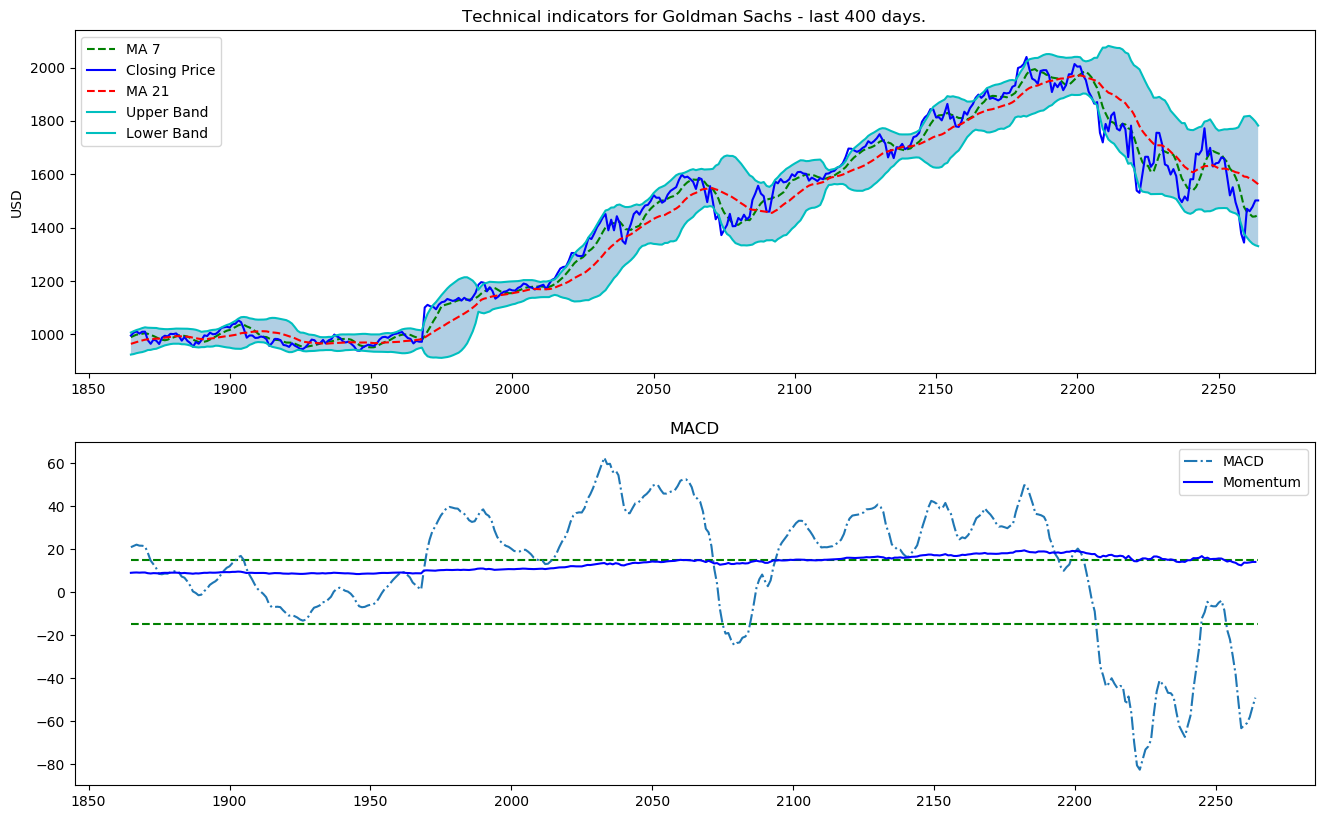

In [12]:
plot_technical_indicators(dataset_TI_df, 400)

In [13]:

#what i wanna do: try to get as many features as possible and then run an xgboost with it to see if i can 
# train the LSTM that way. Will compare it with a Twitter based sentimental analysis LSTM. 
#Features include: moving avaerage, bollinger bands, arima, fourier wave transform 

In [14]:
#Fourier transform as a feature 

In [15]:
data_FT = dataset_ex_df[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))


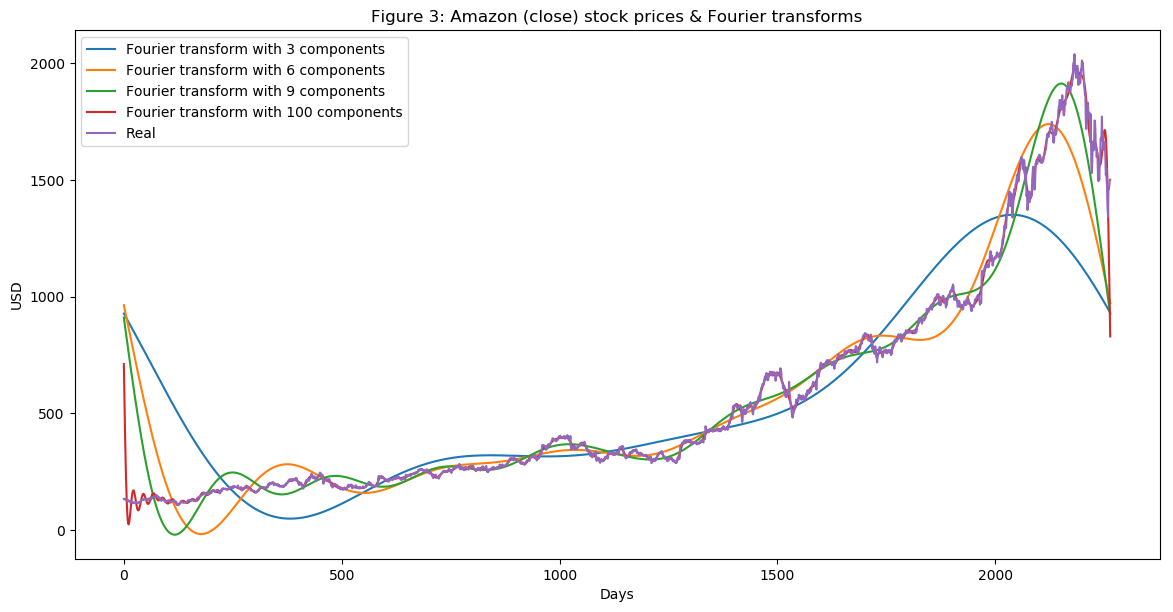

In [16]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Amazon (close) stock prices & Fourier transforms')
plt.legend()
plt.show()


In [17]:
#100 is the closest
def get_fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset



In [18]:
dataset_TI_df = get_fourier(dataset_ex_df)

In [19]:

dataset_TI_df.head(30)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,NaN,133.520004,NaN
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,NaN,130.309998,NaN
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,NaN,127.349998,NaN
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,129.110001,NaN,129.110001,NaN
8,2010-01-14,129.139999,130.380005,126.400002,127.349998,9774900,129.984286,NaN,130.496376,129.999802,-0.496574,NaN,NaN,NaN,127.879659,0.2735,127.349998,NaN,127.349998,NaN
9,2010-01-15,129.179993,129.649994,127.059998,127.139999,15376500,129.254285,NaN,130.033228,129.457870,-0.575358,NaN,NaN,NaN,127.386544,0.2714,127.139999,NaN,127.139999,NaN


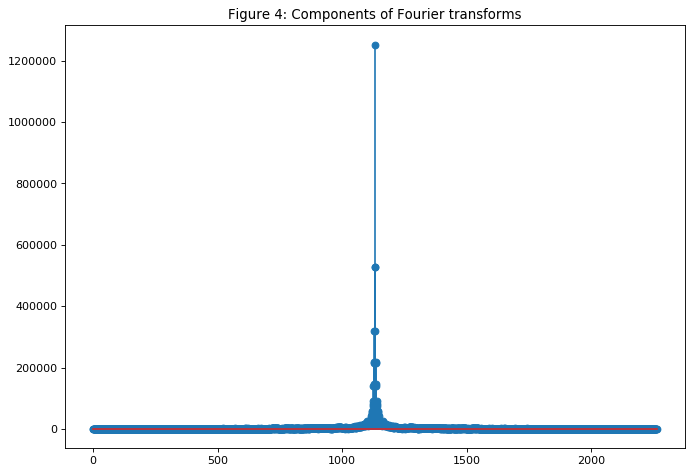

In [20]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [21]:
#Arima as a feature

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9244.973
Method:                       css-mle   S.D. of innovations             14.361
Date:                Thu, 25 Jul 2019   AIC                          18503.947
Time:                        18:17:25   BIC                          18544.021
Sample:                             1   HQIC                         18518.569
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6074      0.291      2.086      0.037       0.037       1.178
ar.L1.D.Close    -0.0270      0.021     -1.287      0.198      -0.068       0.014
ar.L2.D.Close    -0.0002      0.021     

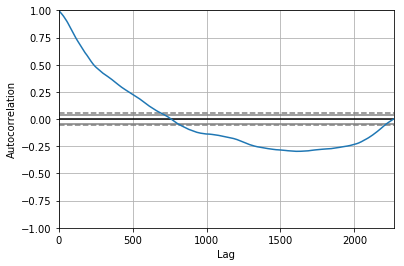

<Figure size 800x560 with 0 Axes>

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [24]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions) 

In [25]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


Test MSE: 557.865


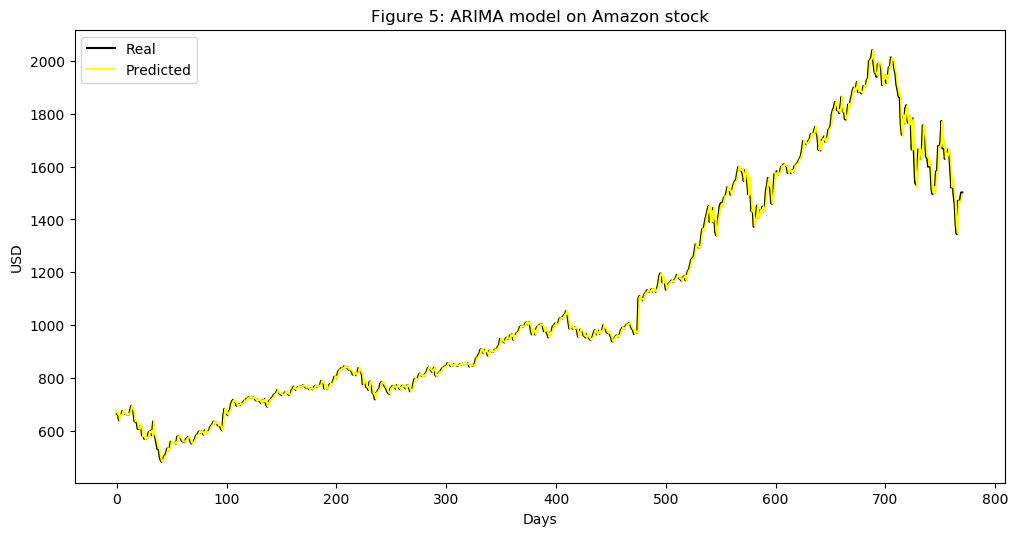

In [26]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Amazon stock')
plt.legend()
plt.show()


In [27]:
dataset_ex_df.head(8)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,678.303784,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,664.043067,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,663.388475,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,640.204417,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.576569,133.520004,NaN
5,2010-01-11,132.619995,132.800003,129.210007,130.309998,8779400,NaN,NaN,132.294735,132.126083,-0.168651,NaN,NaN,NaN,131.095247,0.3031,130.309998,658.990696,130.309998,NaN
6,2010-01-12,128.990005,129.820007,126.550003,127.349998,9096300,131.717142,NaN,131.415339,131.060317,-0.355022,NaN,NaN,NaN,128.597272,0.2735,127.349998,676.445683,127.349998,NaN
7,2010-01-13,127.900002,129.710007,125.750000,129.110001,10723200,131.032858,NaN,131.043892,130.653316,-0.390576,NaN,NaN,NaN,128.939143,0.2911,129.110001,669.110593,129.110001,NaN


In [28]:
print('Total dataset has {} samples, and {} features.'.format(dataset_ex_df.shape[0], \
                                                              dataset_ex_df.shape[1]))

Total dataset has 2265 samples, and 20 features.


In [29]:
#FINDING IMPORTANT FEATURES USING XGBOOST

In [30]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [31]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [32]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [33]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[18:20:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [34]:
eval_result = regressor.evals_result()

In [35]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

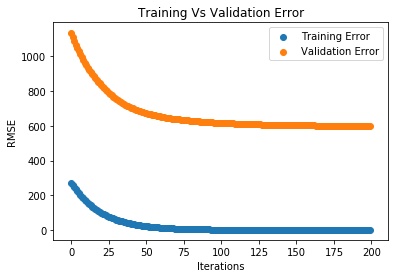

In [36]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

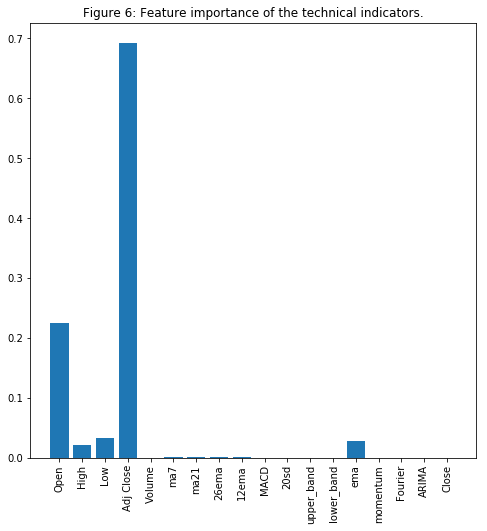

In [37]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()


In [306]:
##next steps:
#we know which features are important. I suspect Fourier and Arima might be equally important but because of their
#spectral component they have not been calculated so we will retain both of them 
# We will input all 17 important features into the LSTM and then  try to run a GAN with a CNN as discriminator and LSTM as 
# generator

In [307]:
#LSTM

In [308]:
#1. take dataframe and drop na
dataset_lstm_df = dataset_TI_df.dropna()
dataset_lstm_df = dataset_lstm_df.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close
20,118.790001,118.980003,114.400002,118.120003,23079700,121.567144,126.572857,124.656320,122.987114,-1.669206,4.823779,135.854058,116.558943,119.068111,0.1812,118.120003,609.313656,118.120003
21,117.120003,119.610001,116.559998,119.099998,12405900,121.394287,125.868096,124.151970,122.373546,-1.778424,4.636742,134.700485,116.153516,119.089369,0.1910,119.099998,608.037491,119.099998
22,118.639999,120.330002,115.739998,115.940002,12784000,120.888573,124.975239,123.418807,121.362079,-2.056729,4.804807,134.221114,115.001887,116.989791,0.1594,115.940002,619.644591,115.940002
23,115.879997,117.650002,114.099998,117.389999,11024800,120.122858,124.267620,122.888619,120.739696,-2.148923,4.887152,133.755304,114.206697,117.256596,0.1739,117.389999,618.845864,117.389999
24,119.379997,121.000000,116.559998,116.830002,9890200,118.808573,123.640477,122.363097,120.128825,-2.234272,4.588413,132.323326,113.969674,116.972200,0.1683,116.830002,580.290401,116.830002
25,118.199997,119.089996,117.000000,118.029999,9223000,117.754287,122.902857,121.991946,119.801678,-2.190268,4.397009,131.326519,113.738482,117.677399,0.1803,118.029999,595.290072,118.029999
26,118.000000,118.610001,116.000000,117.360001,6233200,117.538572,122.286191,121.599740,119.421860,-2.177880,4.388361,130.809723,113.256278,117.465800,0.1736,117.360001,571.293211,117.360001


In [309]:
print('Total dataset has {} samples, and {} features.'.format(dataset_lstm_df.shape[0], \
                                                              dataset_lstm_df.shape[1]))

Total dataset has 751 samples, and 18 features.


In [413]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [414]:
#We need to choose certain features and then find their LSTM and then finally get an output that helps predict closing data
#features to be selected: Open, Adj_Close and ema
# Features like ARIMA and FOURIER will not be used now since they have spectrum components

In [415]:
#creating lstm networks

In [416]:
#creating test, train and validate trains
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])

In [417]:
#1. LSTM for Open. Take Open
open_training = train.iloc[:, 1:2].values

In [418]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450):
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])

In [419]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

In [425]:
#training it
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])
model.fit(features_set_1, labels, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels))

Epoch 1/100
390/390 [==============================] - 5s 14ms/step - loss: 0.1008 - acc: 0.0000e+00
Epoch 2/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0564 - acc: 0.0000e+00
Epoch 3/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0571 - acc: 0.0000e+00
Epoch 4/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0552 - acc: 0.0000e+00
Epoch 5/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0554 - acc: 0.0000e+00
Epoch 6/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0569 - acc: 0.0000e+00
Epoch 7/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0586 - acc: 0.0000e+00
Epoch 8/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0553 - acc: 0.0000e+00
Epoch 9/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0552 - acc: 0.0000e+00
Epoch 10/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0544 - acc: 0.0000e+0

In [426]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

In [427]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

In [428]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [429]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [430]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [431]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [432]:
#make predictions
predictions = model.predict(test_features)

In [433]:
predictions = scaler.inverse_transform(predictions)

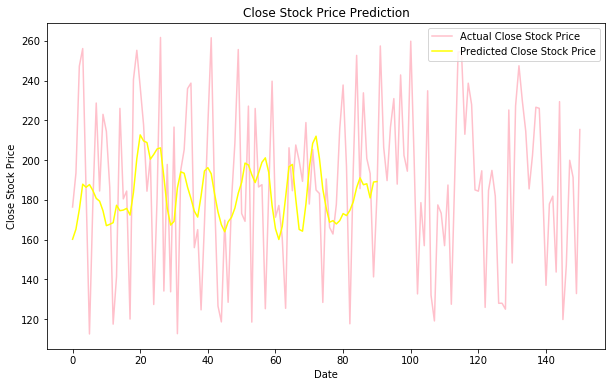

In [440]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Close Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Close Stock Price')
plt.title('Close Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Stock Price')
plt.legend()
plt.show()

In [443]:
#2. LSTM for Adj Close. Take Adj CLose
Adj_close_training = train.iloc[:,4:5].values

In [444]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
Adj_close_training = scaler.fit_transform(Adj_close_training)
#convert to right shape
features_set_2 = []
labels_2 = []
for i in range(60,450):
    features_set_2.append(Adj_close_training[i-60:i, 0])
    labels_2.append(Adj_close_training[i, 0])

In [445]:
features_set_2, labels_2 = np.array(features_set_2), np.array(labels_2)
features_set_2 = np.reshape(features_set_2, (features_set_2.shape[0], features_set_2.shape[1], 1))

In [446]:
#training it
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_2.shape[1], 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(units = 1))
model1.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])
model1.fit(features_set_2, labels, epochs = 60, batch_size = 32,validation_data = (features_set_2, labels))

Train on 390 samples, validate on 390 samples
Epoch 1/60
390/390 [==============================] - 7s 18ms/step - loss: 0.1375 - acc: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 2/60
390/390 [==============================] - 3s 8ms/step - loss: 0.0564 - acc: 0.0000e+00 - val_loss: 0.0633 - val_acc: 0.0000e+00
Epoch 3/60
390/390 [==============================] - 3s 8ms/step - loss: 0.0601 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 4/60
390/390 [==============================] - 3s 8ms/step - loss: 0.0563 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 5/60
390/390 [==============================] - 3s 8ms/step - loss: 0.0568 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 6/60
390/390 [==============================] - 3s 8ms/step - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 7/60
390/390 [==============================] - 3s 8ms/step - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.

In [374]:
#TESTING THE MODEL

adj_testing_processed = test.iloc[:, 4:5].values

In [375]:
#convert test data to right format
Aclose_total = pd.concat((train['Adj Close'], test['Adj Close']), axis=0)

In [376]:
test_inputs = Aclose_total[len(Aclose_total) - len(test) - 60:].values

In [377]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [378]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [379]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [380]:
#make predictions
predictions = model.predict(test_features)

In [381]:
predictions = scaler.inverse_transform(predictions)

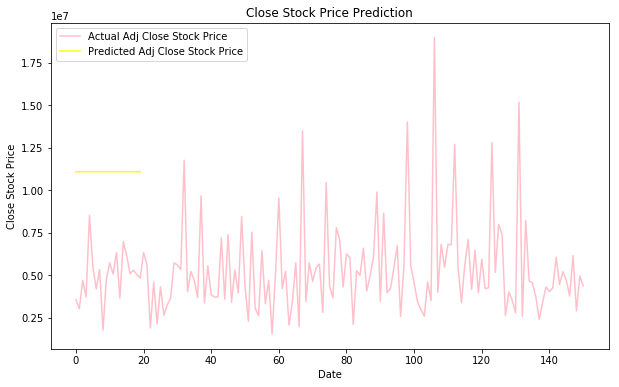

In [382]:
plt.figure(figsize=(10,6))
plt.plot(adj_testing_processed, color='pink', label='Actual Adj Close Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Adj Close Stock Price')
plt.title('Close Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Stock Price')
plt.legend()
plt.show()

In [383]:
#3. LSTM for ema
ema_training = train.iloc[:, 14:15].values

In [384]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
ema_training = scaler.fit_transform(ema_training)
#convert to right shape
features_set = []
labels = []
for i in range(60,450):
    features_set.append(ema_training[i-60:i, 0])
    labels.append(ema_training[i, 0])

In [385]:
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [387]:
#training it
model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(units = 1))
model2.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['ac])curacy'])
model2.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
390/390 [==============================] - 5s 12ms/step - loss: 0.1043
Epoch 2/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0601
Epoch 3/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0576
Epoch 4/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0562
Epoch 5/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0581
Epoch 6/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0564
Epoch 7/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0576
Epoch 8/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0574
Epoch 9/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0562
Epoch 10/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0597
Epoch 11/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0646
Epoch 12/100
390/390 [==============================] - 2s 6ms/step - loss: 0.0579
Epoch 13/100

In [389]:
#testing LSTM
ema_testing_processed = test.iloc[:,14:15].values

In [390]:
#convert test data to right format
ema_total = pd.concat((train['ema'], test['ema']), axis=0)

In [391]:
test_inputs = ema_total[len(ema_total) - len(test) - 60:].values

In [392]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [406]:
test_features = []
for i in range(60,151):
    test_features.append(test_inputs[i-60:i, 0])

In [407]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [408]:
#make predictions
predictions = model.predict(test_features)

In [409]:
predictions = scaler.inverse_transform(predictions)

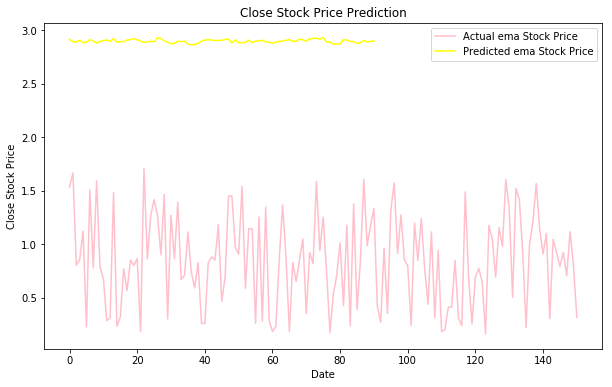

In [410]:
plt.figure(figsize=(10,6))
plt.plot(ema_testing_processed, color='pink', label='Actual ema Stock Price')
plt.plot(predictions , color='yellow', label='Predicted ema Stock Price')
plt.title('Close Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Stock Price')
plt.legend()
plt.show()

In [526]:
#USING 6 FEATURES : lets use adjacent close and open in this LSTM 
#ITS QUITE OBVIOUS THAT NOT 1 FEATURE WILL WORK SO WE USE THE 6 FEATURES THAT
#COULD GENERATE THE BEST OUTCOME FROM XGBOOST

In [623]:
dataset = dataset_TI_df[['Open', 'Close','High','Adj Close','Low']]

In [624]:
dataset

,Open,Close,High,Adj Close,Low
20,118.790001,118.120003,118.980003,118.120003,114.400002
21,117.120003,119.099998,119.610001,119.099998,116.559998
22,118.639999,115.940002,120.330002,115.940002,115.739998
23,115.879997,117.389999,117.650002,117.389999,114.099998
24,119.379997,116.830002,121.000000,116.830002,116.559998
25,118.199997,118.029999,119.089996,118.029999,117.000000
26,118.000000,117.360001,118.610001,117.360001,116.000000
27,117.209999,120.089996,120.419998,120.089996,116.500000
28,118.989998,119.660004,119.940002,119.660004,117.500000
29,120.059998,117.529999,120.500000,117.529999,117.180000


In [625]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [626]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


In [627]:
# FOR REPRODUCIBILITY
np.random.seed(7)


In [628]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])

In [629]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [630]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]


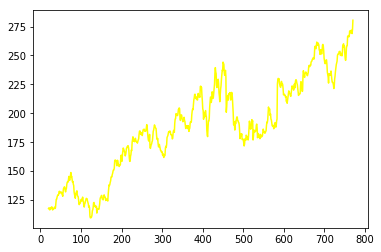

In [631]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.show()


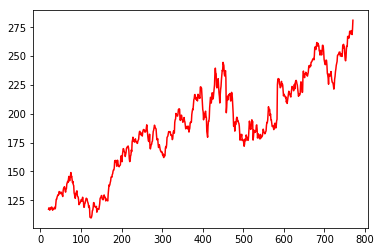

In [632]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.show()

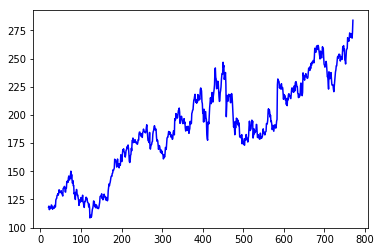

In [633]:
plt.plot(close_val, 'blue', label = 'Closing price')

In [634]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)


In [635]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [636]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [637]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [638]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [641]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mse']) # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 9s - loss: 7.0009e-04 - mean_squared_error: 7.0009e-04
Epoch 2/5
 - 4s - loss: 5.5394e-04 - mean_squared_error: 5.5394e-04
Epoch 3/5
 - 4s - loss: 5.5589e-04 - mean_squared_error: 5.5589e-04
Epoch 4/5
 - 4s - loss: 5.5152e-04 - mean_squared_error: 5.5152e-04
Epoch 5/5
 - 4s - loss: 5.3963e-04 - mean_squared_error: 5.3963e-04


In [611]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [612]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [613]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))


Train RMSE: 4.01


In [614]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 13.95


In [615]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict


In [616]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [617]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

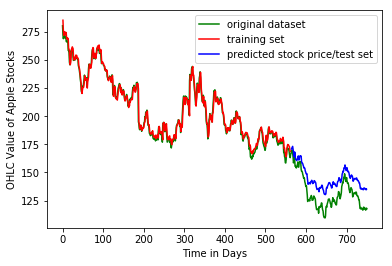

In [620]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Amazon Stocks')
plt.show()

In [622]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Day Value: 135.08642578125
Next Day Value: 138.97373962402344
